In [6]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle

import re

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline



In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize


In [8]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:

df = pd.read_csv('amazon_reviews.csv') 
df.head()

,id,reviewerName,overall,Description,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


In [10]:
df.drop_duplicates(subset ="Description", keep = "first", inplace = True)

In [11]:
df.shape

(4913, 12)

In [12]:
df['Description'] = df['Description'].astype('str')

In [13]:
#df.dropna()


In [14]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


df['Polarity'] = df['Description'].apply(get_polarity)

In [62]:
df['Sentiment_Type']=''
df.loc[df.Polarity>0,'Sentiment_Type']='POSITIVE'
df.loc[df.Polarity==0,'Sentiment_Type']='NEUTRAL'
df.loc[df.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [16]:
df['Sentiment_Type'].value_counts()

POSITIVE    4161
NEGATIVE     469
NEUTRAL      283
Name: Sentiment_Type, dtype: int64

<AxesSubplot:title={'center':'Sentiment Analysis'}>

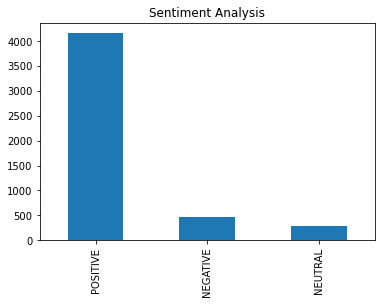

In [17]:
df.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

In [18]:
# Apply first level cleaning
import re
import string

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned = lambda x: text_clean(x)

In [33]:
# Let's take a look at the updated text
df['Description'] = pd.DataFrame(df.Description.apply(cleaned))
df.head(10)

,id,reviewerName,overall,Description,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,Polarity,Sentiment_Type
0,1,0mie,5.0,purchased this for my device it worked as adve...,2013-10-25,409,0,0,0,0,0.0,0.000000,0.200000,POSITIVE
1,2,1K3,4.0,it works as expected i should have sprung for ...,2012-12-23,715,0,0,0,0,0.0,0.000000,0.129167,POSITIVE
2,3,1m2,5.0,this think has worked out greathad a diff bran...,2013-11-21,382,0,0,0,0,0.0,0.000000,0.000000,NEUTRAL
3,4,2&amp;1/2Men,5.0,bought it with retail packaging arrived legit ...,2013-07-13,513,0,0,0,0,0.0,0.000000,0.386667,POSITIVE
4,5,2Cents!,5.0,its mini storage it doesnt do anything else a...,2013-04-29,588,0,0,0,0,0.0,0.000000,-0.025000,NEGATIVE
5,6,2K1Toaster,5.0,i have it in my phone and it never skips a bea...,2013-10-19,415,0,0,0,0,0.0,0.000000,0.233333,POSITIVE
6,7,"35-year Technology Consumer ""8-tracks to 802.11""",5.0,its hard to believe how affordable digital has...,2014-10-07,62,0,0,0,0,0.0,0.000000,0.085417,POSITIVE
7,8,4evryoung,5.0,works in a htc rezound was running short of s...,2014-03-24,259,1,0,1,1,1.0,0.206549,0.100000,POSITIVE
8,9,53rdcard,5.0,in my galaxy super fast card and am totally h...,2013-11-10,393,0,0,0,0,0.0,0.000000,0.233333,POSITIVE
9,10,808TREX50,5.0,i like this sd card because it can take music ...,2013-11-05,398,0,0,0,0,0.0,0.000000,0.334422,POSITIVE


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split

X=df["Description"] 
y = df["Polarity"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state =42)


In [46]:
 
#X_train[0:10]
X_train.shape

(3930,)

In [47]:
 X_test.shape

(983,)

In [48]:
 y_train.shape

(3930,)

In [49]:
y_test.shape

(983,)

In [50]:
y_train

3435    0.131410
410     0.403333
1048    0.106667
4255    0.271429
3260    0.533333
          ...   
4427    0.260000
466     0.288889
3093    0.281111
3773    0.442857
860     0.095238
Name: Polarity, Length: 3930, dtype: float64

In [51]:
X_train

3435    the card i received works perfectly in my sams...
410     for the price it was a great buy i would recom...
1048    prosmaximum external storage for my  of space ...
4255    im not going to go into any technical specific...
3260    i bought this for my samsung  acitve it fit pe...
                              ...                        
4427    its pretty much a commodity product made in th...
466     purchased this as a memory addition for the su...
3093    this is a high quality easy to use product rea...
3773    advertised speedworks right out of the box no ...
860     the advertisement calls this card a class  car...
Name: Description, Length: 3930, dtype: object

In [52]:
y_train

3435    0.131410
410     0.403333
1048    0.106667
4255    0.271429
3260    0.533333
          ...   
4427    0.260000
466     0.288889
3093    0.281111
3773    0.442857
860     0.095238
Name: Polarity, Length: 3930, dtype: float64

In [63]:
df2 = [X_train,y_train] 

data = {'Description': X_train,
        'Polarity': y_train }
 
# Create DataFrame
df2 = pd.DataFrame(data)

In [60]:
df2 

,Description,Polarity
3435,the card i received works perfectly in my sams...,0.131410
410,for the price it was a great buy i would recom...,0.403333
1048,prosmaximum external storage for my of space ...,0.106667
4255,im not going to go into any technical specific...,0.271429
3260,i bought this for my samsung acitve it fit pe...,0.533333
...,...,...
4427,its pretty much a commodity product made in th...,0.260000
466,purchased this as a memory addition for the su...,0.288889
3093,this is a high quality easy to use product rea...,0.281111
3773,advertised speedworks right out of the box no ...,0.442857


,Description,Polarity,Sentiment_Type
3435,the card i received works perfectly in my sams...,0.131410,POSITIVE
410,for the price it was a great buy i would recom...,0.403333,POSITIVE
1048,prosmaximum external storage for my of space ...,0.106667,POSITIVE
4255,im not going to go into any technical specific...,0.271429,POSITIVE
3260,i bought this for my samsung acitve it fit pe...,0.533333,POSITIVE
2916,bought it for my lg android phone and in the ...,-0.150000,NEGATIVE
3387,i bought exactly the same micro sdhc sandisk u...,-0.026144,NEGATIVE
305,works as expectedlove having more room for pic...,0.000000,NEUTRAL
3367,works great in my samsung galaxy also use a s...,-0.008333,NEGATIVE
2860,i bought this memory chip for a gopro hero ca...,0.331250,POSITIVE


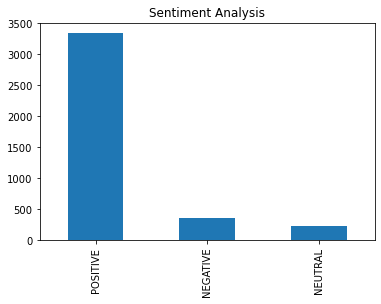

In [66]:
df2.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

df2['Description'] = pd.DataFrame(df2.Description.apply(cleaned))
df2.head(10)